# Visualisation des données de couverture nuageuse ISCCP
#### Couverture nuageuse de chaque étage, Evolution temporelle, cartes spatiales, coupes verticales


In [11]:
##### IMPORTATION DES MODULES #####

import os

import netCDF4 as nc

import math
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib import cm

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from myfunctions import *

from scipy import interpolate
from scipy.interpolate import griddata

In [22]:
######### EXTRACTION DES DONNEES DE COUVERTURE NUAGEUSE CERES ##########

# Where to save images
rep0 = './quicklooks/'
# If the directory does not exist, we create it
if not(os.path.exists(rep0)):
    os.makedirs(rep0)

# Projection for plotting
proj = ccrs.LambertConformal(central_latitude = 37,
                             central_longitude = 10,
                             standard_parallels = (37, 37)
                            )

var1 = 'cltisccp'
var2 = 'albisccp'
var3 = 'pctisccp'
var = 'clt'

#data3d = (time,lat,lon,var)
data3d = np.zeros((300,101,153,3))
data3d[:] = np.nan

fin = 'cltisccp_198307-200806_regrid_ALADIN_bilinear.nc'
fin2 = 'albisccp_198307-200806_regrid_ALADIN_bilinear.nc'
fin3 = 'pctisccp_198307-200806_regrid_ALADIN_bilinear.nc'

d = nc.Dataset(fin)
d2 = nc.Dataset(fin2)
d3 = nc.Dataset(fin3)

data = d[var1][:,:,:]
data2 = d2[var2][:,:,:]
data3 = d3[var3][:,:,:]

data3d[:,:,:,0] = data[:,:,:]
data3d[:,:,:,1] = data2[:,:,:]
data3d[:,:,:,2] = data3[:,:,:]

lat = d['latitude'][:,:]
lon = d['longitude'][:,:]

d.close()
d2.close()
d3.close()


### -- to nan ###

#data_filtre = (time,lat,lon,var)
data_filtre = np.zeros((300,101,153,3))
data_filtre[:] = np.nan

for k in range(300):
    for i in range(101):
        for j in range(153):
            for m in range(3):
                if data3d[k,i,j,m]>=0 and data3d[k,i,j,m]<=100000:
                    data_filtre[k,i,j,m] = data3d[k,i,j,m]
                else:
                    data_filtre[k,i,j,m] = np.nan 

### on supprime le bug du mois de juin (abscence de donnees au nord) ###              
                
for a in range(25):
    for i in range(101):
        for j in range(153):
            if Lat[i,j]>53:
                if data_filtre[12*a+5,i,j,0]<60:
                    data_filtre[12*a+5,i,j,0] = np.nan
                if data_filtre[12*a+5,i,j,2]<40000:
                    data_filtre[12*a+5,i,j,2] = np.nan
                    
                

(72, 144)


In [3]:
####### MOYENNE CLIMATO 1983-2007 #########

### Temporal mean - season

#data_saison =(season,year,lat,lon)
data_season = np.zeros((4,24,101,153))
data_season[:] = np.nan

for i in range(24):
    if i==0:
        data_season[0,i,:,:] = np.nanmean(data_filtre[(6+12*i):(8+12*i),:,:],axis=0)
    else:
        data_season[0,i,:,:] = np.nanmean(data_filtre[(5+12*i):(8+12*i),:,:],axis=0)
    data_season[1,i,:,:] = np.nanmean(data_filtre[(8+12*i):(11+12*i),:,:],axis=0)
    data_season[2,i,:,:] = np.nanmean(data_filtre[(11+12*i):(14+12*i),:,:],axis=0)
    data_season[3,i,:,:] = np.nanmean(data_filtre[(14+12*i):(17+12*i),:,:],axis=0)

data_season_moy = np.nanmean(data_season,axis=1)
#data_season_moy =(season,lat,lon)

### Temporal mean _ anual

data_moy_inter = np.nanmean(data_filtre,axis=0)

### Temporal_mean - month

#data_month = (time,year,lat,lon)
data_month = np.zeros((12,24,101,153))
data_month[:] = np.nan

for i in range(24):
    for j in range(12):
        data_month[j,i,:,:] = data_filtre[(j+6+12*i),:,:]
        
data_month_moy = np.nanmean(data_month,axis=1)
#data_month_moy = (time,lat,lon)


##### DETERMINATION DES BOITES #####

#North Atlantic (-30W,45N / -21,55N)
#Eastern europe (20E,50N / 30E,55N)
#Western Mediterranean (3E,37N / 8.5E,42.5N)
#Eastern Mediterranean (15E,33N / 22E,37N)
#Western Sahara (-6W,20N / 4E,27N)
#Eastern Sahara (24E,19N / 30E,25N)

nt,nlat,nlon = data.shape

    
lat_min = [45,50,37,33,20,19]
lat_max = [55,55,42.5,37,27,25]
lon_min = [-30,20,3,15,-6,24]
lon_max = [-21,30,8.5,22,4,30]

# find coords of nearest point in grid from point (TARGET_LAT, TARGET_LON)
    
target_x = [[],[],[],[],[],[]]
target_y = [[],[],[],[],[],[]]
 
for x in range(nlon):
    for y in range(nlat):
        for i in range(6):
            if lat[y,x]>=lat_min[i] and lat[y,x]<=lat_max[i] and lon[y,x]>=lon_min[i] and lon[y,x]<=lon_max[i]:
                target_x[i].append(x)
                target_y[i].append(y)

print(len(target_x[4]))

# Temporal mean - box

data_boite=np.zeros((12,336,6))
data_boite[:]=np.nan
data_boite_moy=np.zeros((12,336,6))
data_boite_moy[:]=np.nan

for j in range(12):
    for i in range(6):
        for k in range(len(target_x[i])):
            data_boite[j,k,i] =  data_month_moy[j,target_y[i][k],target_x[i][k]] 

data_boite_moy = np.nanmean(data_boite,axis=1)

print(data_moy_inter)



ValueError: could not broadcast input array from shape (101,153,3) into shape (101,153)

Text(0.5,1,'Total Cloud Fraction (%) - 1983-2007')

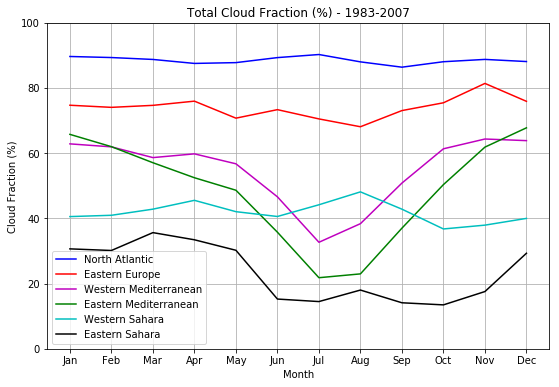

In [26]:
####### PLOT BOX #######
'''
fig=plt.figure(figsize=(12,8))
plt.plot(data_month_moy[:,58,63,0],label='Cll',color='r')
plt.plot(data_month_moy[:,58,63,1],label='Clm',color='m')
plt.plot(data_month_moy[:,58,63,2],label='Clh',color='g')
plt.plot(data_month_moy[:,58,63,3],label='Clt',color='k')
plt.legend()

print('lon=',lon[58,62])
print('lat=',lat[58,62])
'''
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig=plt.figure(figsize=(9,6))
plt.plot(months,data_boite_moy[:,0],label='North Atlantic',color='b')
plt.plot(months,data_boite_moy[:,1],label='Eastern Europe',color='r')
plt.plot(months,data_boite_moy[:,2],label='Western Mediterranean',color='m')
plt.plot(months,data_boite_moy[:,3],label='Eastern Mediterranean',color='g')
plt.plot(months,data_boite_moy[:,4],label='Western Sahara',color='c')
plt.plot(months,data_boite_moy[:,5],label='Eastern Sahara',color='k')
plt.legend()
plt.ylim(0,100)
plt.grid()
plt.xlabel('Month')
plt.ylabel('Cloud Fraction (%)')
plt.title('Total Cloud Fraction (%) - 1983-2007')

Text(0.5,1,'Zonal vertical section - Cloud fraction (%) - Northern Europe - 2007 to 2016')

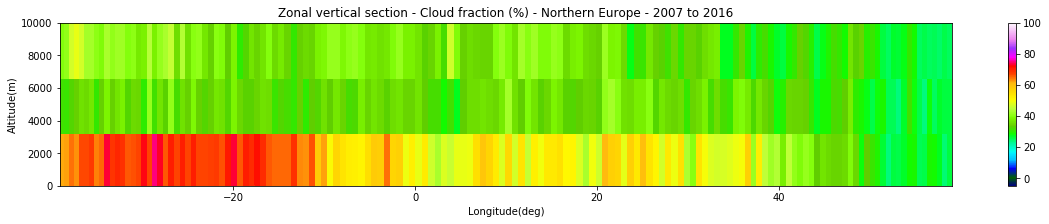

In [13]:
####### COUPES VERTICALES #######

lat_coupe = 85  #indice lat
lon_coupe = 50  #indice lon

z = np.array([0,3200,6600,10000])
lat_liste=lat[:,lon_coupe]
lon_liste=lon[lat_coupe,:]
z_lat,lat_z = np.meshgrid(z,lat_liste)
z_lon,lon_z = np.meshgrid(z,lon_liste)

#utile si utilisation d'un plot en contours
data_moy_inter2 = data_moy_inter
data_moy_inter2[:,:,3] = data_moy_inter2[:,:,2]


fig=plt.figure(figsize=(20,3))

#plt.contourf(lat_z[:,0:4],z_lat[:,0:4],data_moy_inter[:,lat_coupe,0:4]*100,vmin=0,vmax=100,\
#             levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],cmap=cm.gist_ncar)

plt.pcolormesh(lon_z[:,0:4],z_lon[:,0:4],data_moy_inter2[lat_coupe,:,0:4]*100,vmin=-5,vmax=100,cmap=cm.gist_ncar)
plt.xlabel('Longitude(deg)')
plt.ylabel('Altitude(m)')
plt.colorbar()
plt.title('Zonal vertical section - Cloud fraction (%) - Northern Europe - 2007 to 2016')


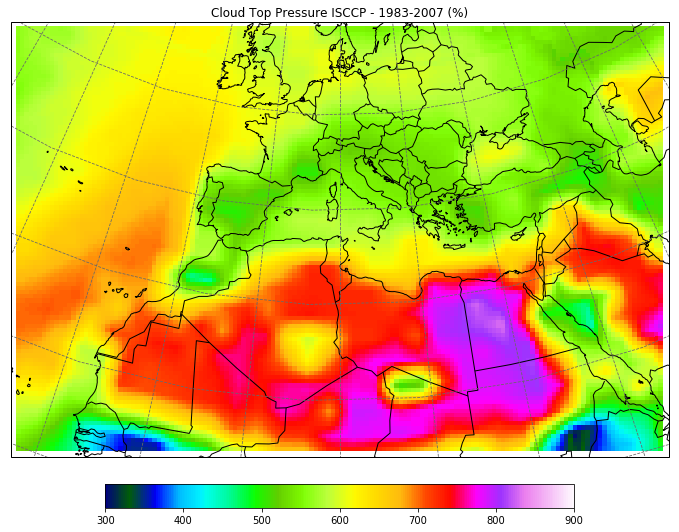

In [17]:
####### PLOTS CARTES #######

# Domain to be plotted
bbox = [-24,44,14,56]
#Map projection is Lambert Conformal (proj)
fig, ax = plt.subplots(figsize=(12,10),subplot_kw=dict(projection=proj))
# Apply domain to be plotted
ax.set_extent(bbox,crs=ccrs.PlateCarree())
# Add coastlines
ax.coastlines('50m')
# Add country borders
ax.add_feature(cf.BORDERS)

# *must* call draw in order to get the axis boundary used to add ticks
fig.canvas.draw()

xticks = range(-180,181,10)
yticks = range(-90,91,10)
ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=1,color='dimgrey')

# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

#lambert_xticks(ax, xticks)
#lambert_yticks(ax, yticks)

#ax.set_title('{0} ({1}) - {2}'.format(name,units,dates[0]))
#ax.set_title('{0} ({1}) - 2007 to 2016'.format(name,units))
ax.set_title('{0} ({1})'.format("Cloud Top Pressure ISCCP - 1983-2007","%"))


# Plot data
cs = ax.pcolormesh(lon,lat,np.nanmean(data_filtre[:,:,:,2],axis=0)/100, transform=ccrs.PlateCarree(),
        cmap=cm.gist_ncar, vmin=300, vmax=900,shading='flat')

# Add colorbar
cbar = fig.colorbar(cs, shrink=0.7, orientation='horizontal',pad=0.05)

# Save in png
#print '{0}/{1}'.format(rep0,var)+str(i+1)+'.png'
#plt.savefig('{0}/{1}_obs_moy.png'.format(rep0,var))
plt.show()
plt.close()


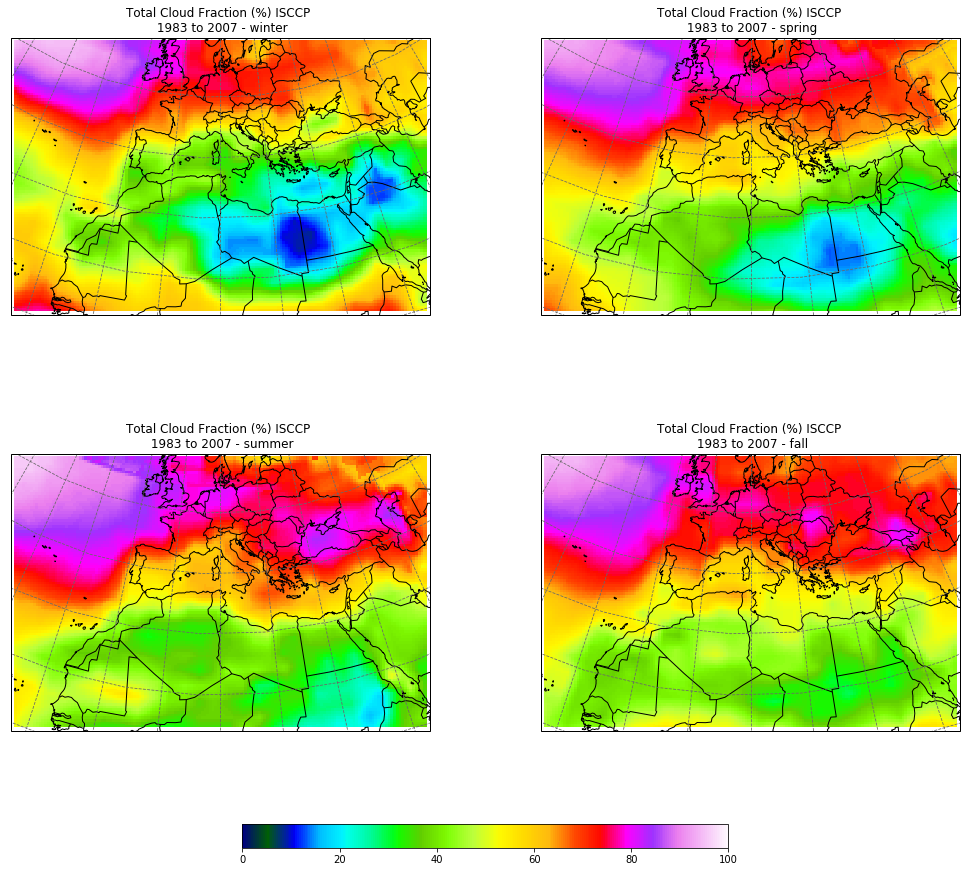

In [23]:
########## SUBPLOTS SEASONS ###########

# Domain to be plotted
bbox = [-24,44,14,56]

# Map projection is Lambert Conformal (proj)
fig, axes = plt.subplots(2,2,figsize=(20,17),subplot_kw=dict(projection=proj))
title_season = ['winter','spring','summer','fall']

for i, ax in enumerate(axes.flat):
	# Apply domain to be plotted
	ax.set_extent(bbox,crs=ccrs.PlateCarree())
		# Add coastlines
	ax.coastlines('50m')
	
		# Add country borders
	ax.add_feature(cf.BORDERS)
	
		# *must* call draw in order to get the axis boundary used to add ticks
	fig.canvas.draw()
	
	xticks = range(-180,181,10)
	yticks = range(-90,91,10)
	ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=1,color='dimgrey')
	
    	# Label the end-points of the gridlines using the custom tick makers:
	ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
	ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
	
	#lambert_xticks(ax, xticks)
	#lambert_yticks(ax, yticks)
	
	
	ax.set_title('Total Cloud Fraction (%) ISCCP \n 1983 to 2007 - {0}'.format(title_season[i]))
	
    	# Plot data
	cs = ax.pcolormesh(lon,lat,data_season_moy[i,:,:], transform=ccrs.PlateCarree(),
        			cmap=cm.gist_ncar, vmin=0., vmax=100.,shading='flat')

# Add colorbar
fig.subplots_adjust(right=0.8, hspace=0.5)
cbar = fig.colorbar(cs, ax=axes[:,:], shrink=0.5, orientation='horizontal',pad=0.1)

# Save in png
#plt.savefig('{0}/{1}_all_seasons_brut_3.png'.format(rep0,var))
plt.show()
plt.close()



In [ ]:
##### PLOT TOUS LES MOIS ##### a modifier la date de depart

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for i in range(1):
    for j in range(12): 
        # Domain to be plotted
        bbox = [-24,44,14,56]
        # Map projection is Lambert Conformal (proj)
        fig, ax = plt.subplots(figsize=(12,10),subplot_kw=dict(projection=proj))
        # Apply domain to be plotted
        ax.set_extent(bbox,crs=ccrs.PlateCarree())
        # Add coastlines
        ax.coastlines('50m')
        # Add country borders
        ax.add_feature(cf.BORDERS)
        
        # *must* call draw in order to get the axis boundary used to add ticks
        fig.canvas.draw()
        
        xticks = range(-180,181,10)
        yticks = range(-90,91,10)
        ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=1,color='dimgrey')
        
        # Label the end-points of the gridlines using the custom tick makers:
        ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
        ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
        
        #lambert_xticks(ax, xticks)
        #lambert_yticks(ax, yticks)
        
        #ax.set_title('{0} ({1}) - {2}'.format(name,units,dates[0]))
        ax.set_title('Total Cloud Fraction(%)- ISCCP - '+str(months[j]+' '+str(i+1983)))
        
        # Plot data
        cs = ax.pcolormesh(lon,lat,data_filtre[i*12+j,:,:], transform=ccrs.PlateCarree(),
        cmap=cm.gist_ncar,vmin=0.,vmax=100.,shading='flat')
        
        # Add colorbar
        cbar = fig.colorbar(cs, shrink=0.7, orientation='horizontal',pad=0.05)
        
        # Save in png
        
        a = 'DiffTot_surf'
    
        plt.savefig('{0}/test_isccp/{1}_isccp_'.format(rep0,var)+str(i*12+j+1)+'_'+str(months[j])+str(i+1983)+'.png')
        plt.show()
        plt.close()
